### Imports###

In [1]:
from train import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import exposure
from skimage.transform import match_histograms
from random import randint


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
hvd.init()
sess = tensorflow_session()

In [1]:
# Restore the parameters

false = False
true = True



param = {"data_dir": "celeba-tfr", "n_train": 50000, "dal": 1, "n_bins": 32.0, "n_bits_x": 5, "inference": false,
         "problem": "celeba", "weight_decay": 1.0, "pmap": 16, "polyak_epochs": 1, "epochs_full_valid": 50,
         "n_levels": 4, "local_batch_test": 1, "epochs_full_sample": 50, "n_sample": 1, "n_y": 1, "rnd_crop": false,
         "category": "", "local_batch_init": 4, "n_batch_train": 64, "train_its": 391, "test_its": 24,
         "full_test_its": 1500, "image_size": 256, "n_batch_test": 50, "lr": 0.0005, "decomposition": "",
         "local_batch_train": 1, "fmap": 1, "epochs_warmup": 10, "verbose": false,
         "restore_path": "/ssd_scratch/cvit/girish.varma/emerging/x_celeb/model_best_loss.ckpt",
         "beta1": 0.9, "ycond": false, "logdir": "", "depth": 16, "weight_y": 0.0, "anchor_size": 32,
         "gradient_checkpointing": 1, "learnprior": true, "top_shape": [16, 16, 96], "width": 512, "flow_coupling": 1,
         "n_batch_init": 256, "flow_permutation": 7, "seed": 2, "optimizer": "adamax", "direct_iterator": true,
         "n_test": 3000, "epochs": 4001, "channels": 3}

param["restore_path"] = param["restore_path"] # You may need to change those fields
param["data_dir"] = param["data_dir"]
param["depth"] = param["depth"]
param["n_levels"] = param["n_levels"]
param["flow_coupling"] = param["flow_coupling"]
param["flow_permutation"] = param["flow_permutation"]

param["inference"] = True

In [4]:
import argparse
parser = argparse.ArgumentParser()
for key in param:
    parser.add_argument("--"+key,type=type(param[key]),default=param[key])
hps = parser.parse_args(args="")


## Initialisation ##

In [5]:
tf.set_random_seed(hvd.rank() + hvd.size() * hps.seed)
np.random.seed(hvd.rank() + hvd.size() * hps.seed)

In [6]:
train_iterator, test_iterator, data_init = get_data(hps, sess)
hps.train_its, hps.test_its, hps.full_test_its = get_its(hps)

Rank 0 Batch sizes Train 1 Test 1 Init 4
Instructions for updating:
Use `dataset.apply(tf.data.experimental.filter_for_shard(...))`.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
3000 1 1
Train epoch size: 50048


In [7]:
import model
model = model.model(sess, hps, train_iterator, test_iterator, data_init)

Instructions for updating:
Colocations handled automatically by placer.
Creating pad 1_1_130_130
Creating pad 1_1_66_66
Creating pad 1_1_34_34
Creating pad 1_1_18_18
Instructions for updating:
Use tf.cast instead.
Restoring params...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /ssd_scratch/cvit/girish.varma/emerging/x_celeb/model_best_loss.ckpt
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
[<tf.Tensor 'model_3/pool0/truediv_1:0' shape=(?, 128, 128, 6) dtype=float32>, <tf.Tensor 'model_3/pool1/truediv_1:0' shape=(?, 64, 64

### Loading pre-computed data###

In [8]:
x = np.load("x_celeb/x_1000.npy")  # Load some images
z = np.load("x_celeb/z_1000.npy")  # Load the corresponding latent representation
attr = np.load("x_celeb/attr_1000.npy") # Load the corresponding attributes

The covariance matrix was computed as $\hat{A}^T\hat{Z}$ where $Z$ is the matrix of the latent representation of a set image (in this case $Z$ had shape (30000,196608)), $A$ is the matrix of the attributes corresponding to each of these images (here $Z$ had shape (30000,40)). $\hat{Z}$ is $Z$ normalized to have zero mean and unit variance.

In [ ]:
cov_raw = np.load("x_celeb/cov.npy")  # Load the covariance matrix

In [9]:
cov = (cov_raw.T / np.abs(cov_raw).sum(axis=1)).T

In [10]:
TAGS = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
TAGS = TAGS.split()

### Inversion test###

In [11]:
idx = randint(0,1000)
y = np.array([0])
image = x[idx]
latent = model.encode(y,image.reshape(1,256,256,3)) # Using the model to encode an image
recons = model.decode(y,latent) # End to decode it

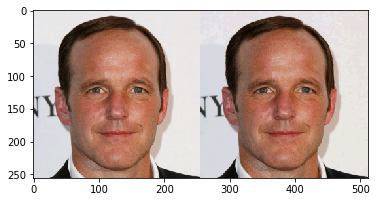

In [12]:
plt.imshow(np.hstack(image[0],recons[0]))
plt.show() # The reconstructed image should be the same as the first one

### Modification example###

In [13]:
# Print all the attributes 
for i, tag in enumerate(TAGS):
    print(i, tag, end="   ")
    if (i+1) % 6 == 0:
        print()

0 5_o_Clock_Shadow   1 Arched_Eyebrows   2 Attractive   3 Bags_Under_Eyes   4 Bald   5 Bangs   
6 Big_Lips   7 Big_Nose   8 Black_Hair   9 Blond_Hair   10 Blurry   11 Brown_Hair   
12 Bushy_Eyebrows   13 Chubby   14 Double_Chin   15 Eyeglasses   16 Goatee   17 Gray_Hair   
18 Heavy_Makeup   19 High_Cheekbones   20 Male   21 Mouth_Slightly_Open   22 Mustache   23 Narrow_Eyes   
24 No_Beard   25 Oval_Face   26 Pale_Skin   27 Pointy_Nose   28 Receding_Hairline   29 Rosy_Cheeks   
30 Sideburns   31 Smiling   32 Straight_Hair   33 Wavy_Hair   34 Wearing_Earrings   35 Wearing_Hat   
36 Wearing_Lipstick   37 Wearing_Necklace   38 Wearing_Necktie   39 Young   

## Modification ##

In [20]:
idx = 42

latent = z[idx].copy() # Copy the latent representation of a given image

boost = list(range(-3000,6000,1000))

latents = []

attribute = 39 # We will modify the age attribute

for alpha in boost:
    latent = z[idx].copy()
    latent += alpha * cov[attribute] # the latent representation is modified by adding the line in the covariance matrix that correspond to the 
                                     # attribute we wish to modify
    latents.append(latent.reshape(1,-1))
    
batch = np.concatenate(latents)
y = np.zeros(len(boost))

In [21]:
recons = model.decode(y, batch) # The modified latent representations are decoded

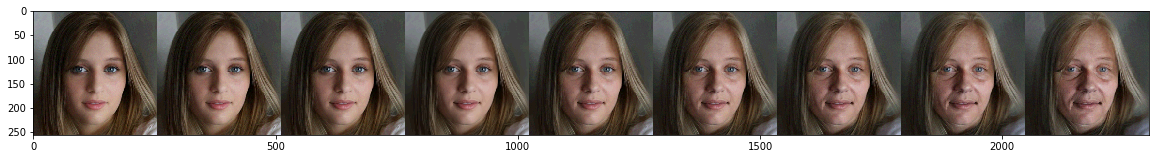

In [22]:
compare = np.zeros((256,2*256+5,3),dtype=int)
compare[:,:256] = x[idx]
compare[:,-256:] = recons[0]
plt.figure(figsize=(20,15))
plt.imshow(np.hstack([*recons]))
plt.show()
